In [1]:
%matplotlib inline
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
from IPython.display import clear_output

In [2]:
class Args():
    def __init__(self):
        self.image_path = "../data/png/anat_2class/"
        self.model_save_path = "../models/"
args = Args()

In [3]:
def load_data(imsize=128, batch_size=2):
    transform = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
    dataset = torchvision.datasets.ImageFolder(root=args.image_path, transform=transform, target_transform=None)
    train_size = int(0.80 * len(dataset))
    test_size =  int(0.20 * len(dataset))+1
    val_size = int(0.10 * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [3442, 500])
    trainloader = torch.utils.data.DataLoader(train_dataset,
                   shuffle=True, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(val_dataset,
                   shuffle=True, batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(val_dataset,
                   shuffle=True, batch_size=batch_size)
    return trainloader, testloader, valloader

In [4]:
trainloader, testloader, valloader = load_data()

In [5]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
class Learner():
    
    def __init__(self):
        self.training_loss_full = []
        self.testing_loss_full = []
        self.validation_loss_full = []
        self.training_loss = []
        self.testing_loss = []
        self.validation_loss = []
        self.train_acc = [] 
        self.test_acc = [] 
        self.val_acc = []
        self.max_train_acc = 0
        
    def train(self, cuda):
        correct = 0
        loss_ = []
        model.train()
        for data, target in (trainloader):
            if cuda:
                data, target = data.to('cuda:0'), target.to('cuda:0')
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss_.append(loss.item())
            softmax_output = torch.exp(output)
            top_p, top_class = softmax_output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            correct += torch.mean(equals.type(torch.FloatTensor)).item()
            loss.backward()
            optimizer.step()
        return loss_, sum(loss_)/len(trainloader), int((correct/len(trainloader))*100)
    
    def test(self, cuda, loader, model):
        correct = 0
        loss_ = []
        model.eval()
        with torch.no_grad():
            for data, target in (loader):
                if cuda:
                    data, target = data.to('cuda:0'), target.to('cuda:0')
                output = model(data)
                loss = criterion(output, target)
                loss_.append(loss.item())
                softmax_output = torch.exp(output)
                top_p, top_class = softmax_output.topk(1, dim=1)
                equals = top_class == target.view(*top_class.shape)
                correct += torch.mean(equals.type(torch.FloatTensor)).item()
            return loss_, sum(loss_)/len(loader), int((correct/len(loader))*100)
    
    def plot(self, list1, list2, list3, title, label1, label2, label3):
        if list1 != []:
            plt.plot(list1, 'b-', label=label1)
        if list2 != []:
            plt.plot(list2, 'r-', label=label2)
        if list3 != []:
            plt.plot(list3, 'y-', label=label3)
        plt.title(title)
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()
        
    def save_model(self, path):
        torch.save(model.state_dict(), os.path.join(path, 'try1.pth'))
    
    def weight_reset(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
            m.reset_parameters()
    
    def fit(self, 
            model, 
            training=True, 
            epoch=5, 
            testing=False, 
            validation=True, 
            plot_loss=True, 
            print_loss=False,
            plot_acc=False,
            print_acc=False, 
            print_all=False, 
            plot_overall_avg=True, 
            cuda=True,
            reset_full_model=False):
        
        if reset_full_model:
            model.apply(self.weight_reset)
        
        if cuda:
            model.to('cuda:0');
        
        for epoch in tqdm(range(epoch)):
            
            
            if training:
                loss_, _loss, training_accuracy = self.train(cuda)
                self.training_loss_full.extend(loss_)
                self.training_loss.append(_loss)
                self.train_acc.append(training_accuracy)
                if self.train_acc[epoch] > self.max_train_acc:
                    max_acc = self.train_acc[epoch]
                    self.save_model(args.model_save_path)
                    
            if testing:
                loss_, _loss, test_accuracy = self.test(cuda, testloader, model)
                self.testing_loss_full.extend(loss_)
                self.testing_loss.append(_loss)
                self.test_acc.append(test_accuracy)
            if validation:
                loss_, _loss, val_accuracy = self.test(cuda, valloader, model)
                self.validation_loss_full.extend(loss_)
                self.validation_loss.append(_loss)
                self.val_acc.append(val_accuracy)
            clear_output()
            
            
            if plot_loss:
                self.plot(self.training_loss, self.validation_loss, self.testing_loss, 'loss', 'train', 'val', 'test')
                
            if plot_acc:
                self.plot(self.train_acc, self.val_acc, self.test_acc, 'acc', 'train', 'val', 'test')
        
            if print_acc:
                print('Training Accuracy:', self.max_train_acc)
                print('Validation Accuracy:', max(self.val_acc))
    
   
    
    def predict(self, 
                model_path,
                cuda=False,
                load_model=False,
                print_acc=True):
        
        if load_model == True:
            model.load_state_dict(torch.load(model_path))
        loss_, _loss, test_accuracy = self.test(cuda, testloader, model)
        print("The test accuracy is {0}%".format(test_accuracy, 0))
        
   
#add model reset
#add transfer learning modules
                
learner = Learner()

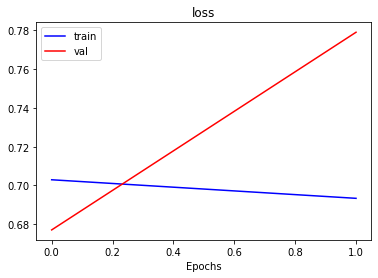

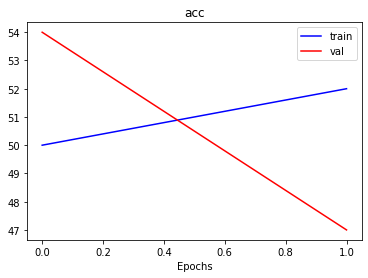

KeyboardInterrupt: 

In [23]:
learner.fit(model, cuda=True, plot_acc=True, epoch=10, reset_full_model=True)

In [30]:
# learner.predict(cuda=True,load_model=True, model_path='../models/try1.pth')

The test accuracy is 99%


In [23]:
# model.load_state_dict(torch.load("../models/try1.pth"))

<All keys matched successfully>

In [24]:
# torch.save(model.state_dict(), "../models/anat_2class_128imsize_98train_97val_99test.pth")

In [37]:
help(nn.Conv1d)

Help on class Conv1d in module torch.nn.modules.conv:

class Conv1d(_ConvNd)
 |  Applies a 1D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, L)` and output :math:`(N, C_{\text{out}}, L_{\text{out}})` can be
 |  precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{\text{out}_j}, k)
 |      \star \text{input}(N_i, k)
 |  
 |  where :math:`\star` is the valid `cross-correlation`_ operator,
 |  :math:`N` is a batch size, :math:`C` denotes a number of channels,
 |  :math:`L` is a length of signal sequence.
 |  
 |  * :attr:`stride` controls the stride for the cross-correlation, a single
 |    number or a one-element tuple.
 |  
 |  * :attr:`padding` controls the amount of implicit zero-paddings on both sides
 |    for :attr:`padding` number of poi

In [47]:
help(model.conv1.reset_parameters())

Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).



In [46]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 